In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import os
import matplotlib.pyplot as plt
import PIL
import seaborn as sns
import plotly
import plotly.graph_objs as go
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from plotly.offline import iplot, init_notebook_mode
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from IPython.display import display
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler

In [2]:
file_lbl=r"C:\Users\Divyansh Kashyap\Desktop\RNN Lab\trainLabels.csv"
df_train=pd.read_csv(file_lbl,sep=',')
df_train

,image,level
0,10_left,0
1,10_right,0
2,13_left,0
3,13_right,0
4,15_left,1
...,...,...
35121,44347_right,0
35122,44348_left,0
35123,44348_right,0
35124,44349_left,0


In [3]:
import glob

In [4]:
image_dir = r'C:\Users\Divyansh Kashyap\Desktop\RNN Lab\resized_train\resized_train'

paths_train = glob.glob(os.path.join(image_dir, '*.jpeg'))

retina_df = pd.read_csv(os.path.join(r'C:\Users\Divyansh Kashyap\Desktop\RNN Lab\resized_train_cropped\resized_train_cropped', file_lbl))

retina_df['PatientId'] = retina_df['image'].map(lambda x: x.split('_')[0])
retina_df['path'] = retina_df['image'].map(lambda x: os.path.join(image_dir, '{}.jpeg'.format(x)))
retina_df['exists'] = retina_df['path'].map(os.path.exists)
print(retina_df['exists'].sum(), 'images found of', retina_df.shape[0], 'total')
retina_df['eye'] = retina_df['image'].map(lambda x: 1 if x.split('_')[-1]=='left' else 0)

35126 images found of 35126 total


In [5]:
from tensorflow.keras.utils import to_categorical
retina_df['level_cat'] = retina_df['level'].map(lambda x: to_categorical(x, 1+retina_df['level'].max()))

retina_df.dropna(inplace = True)
retina_df = retina_df[retina_df['exists']]
retina_df.sample(3)

,image,level,PatientId,path,exists,eye,level_cat
7721,9708_right,0,9708,C:\Users\Divyansh Kashyap\Desktop\RNN Lab\resi...,True,0,"[1.0, 0.0, 0.0, 0.0, 0.0]"
2484,3076_left,0,3076,C:\Users\Divyansh Kashyap\Desktop\RNN Lab\resi...,True,1,"[1.0, 0.0, 0.0, 0.0, 0.0]"
12054,15136_left,0,15136,C:\Users\Divyansh Kashyap\Desktop\RNN Lab\resi...,True,1,"[1.0, 0.0, 0.0, 0.0, 0.0]"


array([[<Axes: title={'center': 'level'}>,
        <Axes: title={'center': 'eye'}>]], dtype=object)

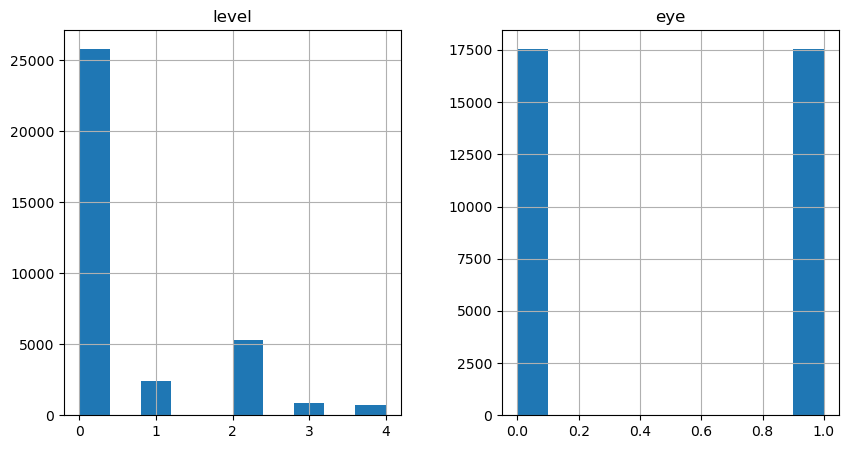

In [6]:
retina_df[['level', 'eye']].hist(figsize = (10, 5))

train 27176 validation 9632
Nouvelle taille de l'ensemble d'entraînement: 98450


C:\Users\Divyansh Kashyap\AppData\Local\Temp\ipykernel_21244\2681964257.py:14: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



array([[<Axes: title={'center': 'level'}>,
        <Axes: title={'center': 'eye'}>]], dtype=object)

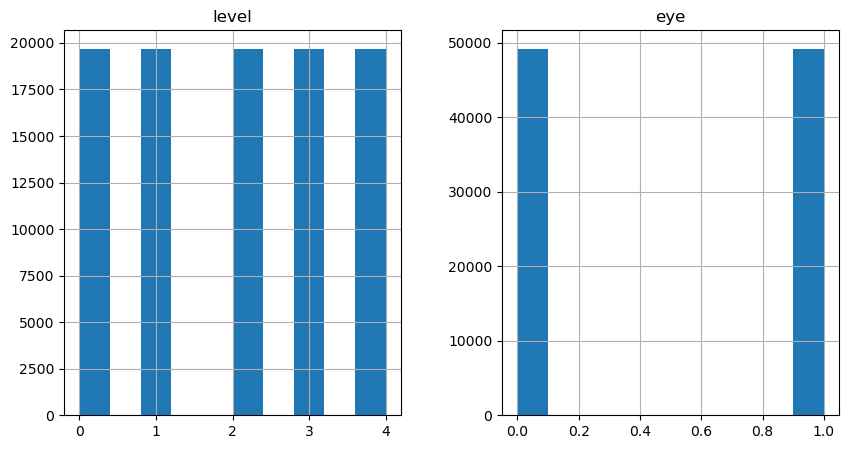

In [7]:
from sklearn.utils import resample
rr_df = retina_df[['PatientId', 'level']].drop_duplicates()

train_ids, valid_ids = train_test_split(rr_df['PatientId'], test_size=0.25, random_state=2018, stratify=rr_df['level'])

raw_train_df = retina_df[retina_df['PatientId'].isin(train_ids)]
valid_df = retina_df[retina_df['PatientId'].isin(valid_ids)]

print(f"train {raw_train_df.shape[0]} validation {valid_df.shape[0]}")


max_samples = raw_train_df.groupby(['level', 'eye']).size().max()

balanced_train_df = raw_train_df.groupby(['level', 'eye'], as_index=False).apply(
    lambda x: resample(x, replace=True, n_samples=max_samples, random_state=42)
).reset_index(drop=True)

print("Nouvelle taille de l'ensemble d'entraînement:", balanced_train_df.shape[0])

balanced_train_df[['level', 'eye']].hist(figsize=(10, 5))


In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.utils import to_categorical

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(
    rescale=1./255
)

def generate_data_from_dataframe(df, datagen, batch_size=32, target_size=(224, 224)):
    while True:
        for start in range(0, len(df), batch_size):
            batch_df = df.iloc[start:start + batch_size]
            images = []
            labels = []
            for _, row in batch_df.iterrows():
                img = load_img(row['path'], target_size=target_size)
                img_array = img_to_array(img)
                images.append(img_array)
                labels.append(row['level_cat'])
            images = np.array(images)
            labels = np.array(labels)
            for x, y in datagen.flow(images, labels, batch_size=batch_size, shuffle=False):
                yield x, y

train_generator = generate_data_from_dataframe(raw_train_df, train_datagen, batch_size=32, target_size=(224, 224))
valid_generator = generate_data_from_dataframe(valid_df, valid_datagen, batch_size=32, target_size=(224, 224))

for images_batch, labels_batch in train_generator:
    break  

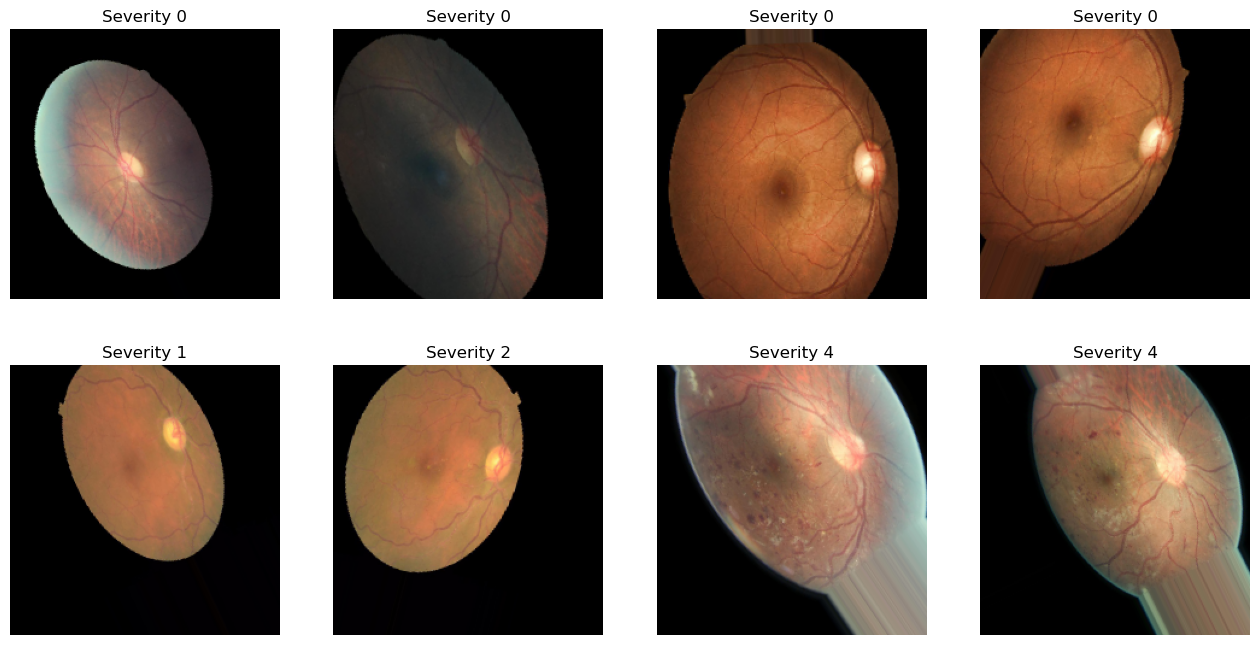

In [9]:
def visualize_augmented_images(generator, batch_size=8):
    t_x, t_y = next(generator)

    fig, m_axs = plt.subplots(2, 4, figsize=(16, 8))
    for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
        c_x = np.clip(c_x * 255, 0, 255).astype(np.uint8)
        c_ax.imshow(c_x)
        c_ax.set_title('Severity {}'.format(np.argmax(c_y)))
        c_ax.axis('off')

    plt.show()

visualize_augmented_images(train_generator)

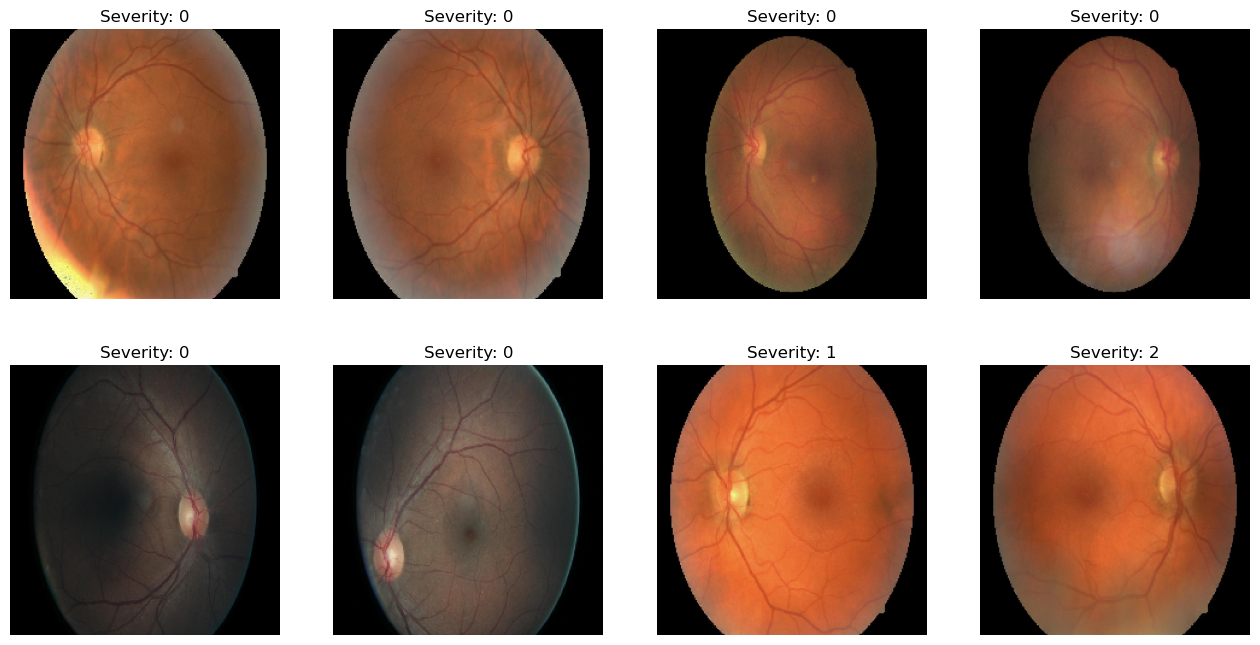

In [10]:
def plot_validation_images(valid_gen):
    v_x, v_y = next(valid_gen) 
    fig, m_axes = plt.subplots(2, 4, figsize=(16, 8))  

    for (img, label, ax) in zip(v_x, v_y, m_axes.flatten()):
        ax.imshow(np.clip(img * 255, 0, 255).astype(np.uint8))
        ax.set_title('Severity: {}'.format(np.argmax(label)))
        ax.axis('off') 

    plt.show()

plot_validation_images(valid_generator)


In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax') 
])


C:\Users\Divyansh Kashyap\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



In [12]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [13]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(raw_train_df) // 32, 
    epochs=2,
    validation_data=valid_generator,
    validation_steps=len(valid_df) // 32
)

Epoch 1/2
849/849 ━━━━━━━━━━━━━━━━━━━━ 96119s 113s/step - accuracy: 0.8130 - loss: 0.5174 - val_accuracy: 0.5000 - val_loss: 12.4238
Epoch 2/2
849/849 ━━━━━━━━━━━━━━━━━━━━ 883s 1s/step - accuracy: 0.9758 - loss: 0.0678 - val_accuracy: 0.5312 - val_loss: 11.7263


In [30]:
validation_steps = len(valid_df) // 32

loss, accuracy = model.evaluate(valid_generator, steps=validation_steps)
print("Loss on the validation set", loss)
print("Accuracy on the validation set:", accuracy)

301/301 ━━━━━━━━━━━━━━━━━━━━ 69s 230ms/step - accuracy: 0.5312 - loss: 11.7264
Loss on the validation set 11.726336479187012
Accuracy on the validation set: 0.53125


In [42]:
from tensorflow.keras.metrics import Precision, Recall

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', Precision(), Recall()])


In [44]:
metrics = model.evaluate(valid_generator, steps=validation_steps)
print("Metrics on the validation set", metrics)


301/301 ━━━━━━━━━━━━━━━━━━━━ 68s 219ms/step - accuracy: 0.5312 - loss: 11.7264 - precision: 0.5312 - recall: 0.5312
Metrics on the validation set [11.726336479187012, 0.53125, 0.53125, 0.53125]


In [46]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# Load the InceptionV3 model pre-trained on ImageNet without the final fully-connected layer
base_model = InceptionV3(weights='imagenet', include_top=False)

# Add new layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(5, activation='softmax')(x)  # num_classes is the number of your classes

# Define the new model
model = Model(inputs=base_model.input, outputs=predictions)


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step


In [48]:
# Freeze all layers of the base InceptionV3 model
for layer in base_model.layers:
    layer.trainable = False


In [50]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [52]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(raw_train_df) // 32,
    epochs=5,  
    validation_data=valid_generator,
    validation_steps=len(valid_df) // 32
)


Epoch 1/5
849/849 ━━━━━━━━━━━━━━━━━━━━ 1225s 1s/step - accuracy: 0.9411 - loss: 0.2457 - val_accuracy: 0.6875 - val_loss: 3.1411
Epoch 2/5
849/849 ━━━━━━━━━━━━━━━━━━━━ 1229s 1s/step - accuracy: 0.9956 - loss: 0.0126 - val_accuracy: 0.4062 - val_loss: 4.8090
Epoch 3/5
849/849 ━━━━━━━━━━━━━━━━━━━━ 1236s 1s/step - accuracy: 0.9961 - loss: 0.0115 - val_accuracy: 0.6875 - val_loss: 3.6576
Epoch 4/5
849/849 ━━━━━━━━━━━━━━━━━━━━ 1254s 1s/step - accuracy: 0.9953 - loss: 0.0136 - val_accuracy: 0.7188 - val_loss: 4.1079
Epoch 5/5
849/849 ━━━━━━━━━━━━━━━━━━━━ 1251s 1s/step - accuracy: 0.9988 - loss: 0.0040 - val_accuracy: 0.7188 - val_loss: 4.0065


In [54]:
for layer in base_model.layers:
    layer.trainable = True

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history_fine = model.fit(
    train_generator,
    steps_per_epoch=len(raw_train_df) // 32,
    epochs=3,
    validation_data=valid_generator,
    validation_steps=len(valid_df) // 32
)

Epoch 1/3
849/849 ━━━━━━━━━━━━━━━━━━━━ 3637s 4s/step - accuracy: 0.9694 - loss: 0.1220 - val_accuracy: 0.3438 - val_loss: 16.3005
Epoch 2/3
849/849 ━━━━━━━━━━━━━━━━━━━━ 3307s 4s/step - accuracy: 1.0000 - loss: 3.5539e-04 - val_accuracy: 0.5312 - val_loss: 5.9735
Epoch 3/3
849/849 ━━━━━━━━━━━━━━━━━━━━ 3286s 4s/step - accuracy: 0.9938 - loss: 0.0232 - val_accuracy: 0.6562 - val_loss: 5.3190


In [58]:
validation_steps = len(valid_df) // 32
loss, accuracy = model.evaluate(valid_generator, steps=validation_steps)
print("Loss on the validation set:", loss)
print("Accuracy on the validation set:", accuracy)


301/301 ━━━━━━━━━━━━━━━━━━━━ 294s 977ms/step - accuracy: 0.6562 - loss: 5.3190
Loss on the validation set: 5.318971633911133
Accuracy on the validation set: 0.65625


In [60]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# Initialize lists to store predictions and true labels
all_predictions = []
all_true_labels = []

# Iterate over the validation generator to collect predictions
for x_batch, y_batch in valid_generator:
    predictions = model.predict(x_batch)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(y_batch, axis=1)
    
    # Append the results to the lists
    all_predictions.extend(predicted_classes)
    all_true_labels.extend(true_classes)
    
    # Stop once enough data has been collected (otherwise it keeps going indefinitely)
    if len(all_true_labels) >= len(valid_df):
        break

# Convert lists to arrays for easier use with scikit-learn
all_predictions = np.array(all_predictions)
all_true_labels = np.array(all_true_labels)

# Compute the confusion matrix and classification report
print("Confusion matrix:")
print(confusion_matrix(all_true_labels, all_predictions))
print("\nClassification report:")
print(classification_report(all_true_labels, all_predictions))


1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

C:\ProgramData\anaco

In [62]:
model.save('mon_modele.h5')

In [64]:
model.save('transfer_model.h5')

In [66]:
model.save("rnn_model.h5")  # or use SavedModel format
